In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [30]:
df = pd.read_csv("data/spy_data.csv")
df = df.drop(df.index[[0,1]])
df = df.rename(columns={"Price" : "Date"})
df["Date"] = pd.to_datetime(df["Date"])
for col in df.select_dtypes(include="object").columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")


In [31]:
df.head()

,Date,Close,High,Low,Open,Volume
2,2015-01-02,171.093643,172.301295,170.052573,171.884867,121465900
3,2015-01-05,168.003769,170.210833,167.695616,170.044264,169632600
4,2015-01-06,166.421371,168.836650,165.621824,168.311946,209151400
5,2015-01-07,168.495163,168.836637,167.304185,167.753921,125346700
6,2015-01-08,171.485153,171.701704,169.894407,169.911055,147217800


In [32]:
df.dtypes

Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
dtype: object

In [131]:
def test_dca(df, interval, invest_monthly):
    df = df.copy()

    # some checking
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").reset_index(drop = True)

    # strategy here is about investing only on mondays 
    mondays = df[df["Date"].dt.day_name() == "Monday"].copy()
    mondays = mondays.iloc[::interval, :]

    amount_per_invest = invest_monthly / (4.33 / interval)


    # simulations
    mondays["Shares"] = amount_per_invest / mondays["Close"] # to know the share of the EFT one's can buy at this time
    mondays["Cumulative_shares"] = mondays["Shares"].cumsum()
    mondays["Total_invested"] = amount_per_invest * np.arange(1, len(mondays) + 1)
    mondays["Portfolio_value"] = mondays["Cumulative_shares"] * mondays["Close"]

    # some stats
    total_invested = mondays["Total_invested"].iloc[-1]
    final_value = mondays["Portfolio_value"].iloc[-1]
    total_return = (final_value - total_invested) / total_invested
    returns = mondays["Portfolio_value"].pct_change().dropna()
    sharpe = np.sqrt(12) * (returns.mean() / returns.std()) if len(returns) > 2 else np.nan

    return {
        "interval_weeks": interval,
        "amount_per_invest": amount_per_invest,
        "total_invested": total_invested,
        "final_value": final_value,
        "total_return": total_return,
        "sharpe": sharpe,
        "timeline": mondays
    }


    


In [128]:
results = []
for w in [1, 2, 4]:
    res = test_dca(df, interval = w, invest_monthly = 1000)
    results.append(res)

summary = pd.DataFrame([
    {
        "Investissement": f"tous les {r['interval_weeks']} lundis",
        "Montant par achat (€)": round(r["amount_per_invest"], 2),
        "Total investi (€)": round(r["total_invested"], 2),
        "Valeur finale (€)": round(r["final_value"], 2),
        "Rendement (%)": round(r["total_return"]*100, 2),
        "Sharpe": round(r["sharpe"], 2)
    }
    for r in results
])
print(summary)


      Investissement  Montant par achat (€)  Total investi (€)  \
0  tous les 1 lundis                 230.95           97228.64   
1  tous les 2 lundis                 461.89           97459.58   
2  tous les 4 lundis                 923.79           97921.48   

   Valeur finale (€)  Rendement (%)  Sharpe  
0          174210.54          79.18    0.92  
1          174812.92          79.37    1.20  
2          175494.69          79.22    1.58  


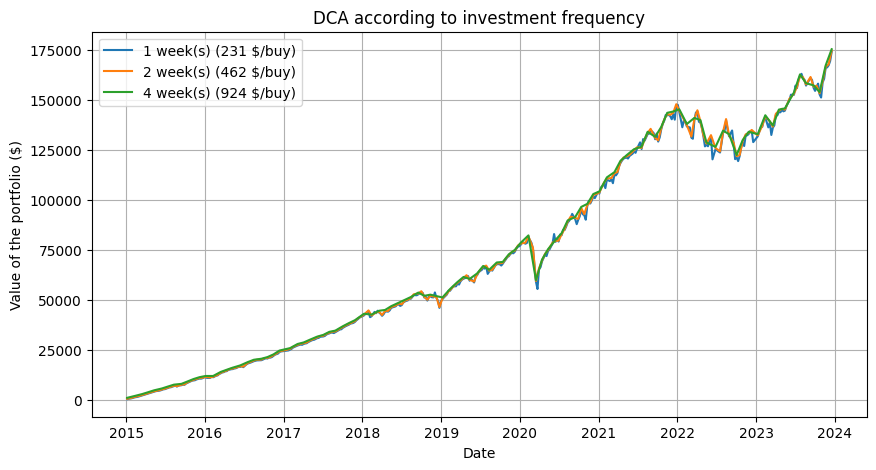

In [136]:
plt.figure(figsize=(10,5))
for r in results:
    plt.plot(r["timeline"]["Date"], r["timeline"]["Portfolio_value"],
             label=f"{r['interval_weeks']} week(s) ({r['amount_per_invest']:.0f} $/buy)")
plt.grid()
plt.title("DCA according to investment frequency")
plt.xlabel("Date")
plt.ylabel("Value of the portfolio ($)")
plt.legend()
plt.show()
